In [1]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 

In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import seaborn as sns
import joblib
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt


2024-05-30 16:56:05.091567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 16:56:05.091693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 16:56:05.229414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
# Audio params
SAMPLE_RATE = 16000
DURATION = 20.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = 512 # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency

# Ada-CNN params
NUM_CLASSES = 2 # bonafide or spoof
BATCH_SIZE = 32 # adjust based on your memory
EPOCHS = 50 # adjust based on your time
LEARNING_RATE = 0.0001 # adjust based on your model performance
N_ESTIMATORS = 10
RANDOM_STATE = 42

In [5]:
base_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [6]:
def read_dataset(protocol_path, directory):
    """Loads the dataset from a protocol file, processes it, and returns a DataFrame."""
    columns = ['speaker_id', 'filename', 'system_id', 'ignore', 'class_name']
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=columns)
    df['filepath'] = df['filename'].apply(lambda filename: os.path.join(directory, filename+'.flac'))
    df.drop(['ignore'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

def convert_class_to_target(class_name):
    """Converts class names to binary target values."""
    return 0 if class_name == 'bonafide' else 1

def add_target_and_subset_columns(df, subset):
    """Enhances DataFrame with target and subset columns based on class name."""
    df['target'] = df['class_name'].apply(convert_class_to_target)
    df['subset'] = subset
    return df

In [7]:
import os
def sample_data(df, num_bonafide, num_spoof):
    """Samples specified numbers of bonafide and spoof records from the DataFrame."""
    bonafide_samples = df[df['class_name'] == 'bonafide'].sample(n=num_bonafide)
    spoof_samples = df[df['class_name'] != 'bonafide'].sample(n=num_spoof)
    return pd.concat([bonafide_samples, spoof_samples])  


def prepare_dataset(protocol_file, data_dir, subset):
    """Reads, adds columns, and samples dataset based on subset specifications."""
    df = read_dataset(os.path.join(protocol_dir, protocol_file), data_dir)
    df = add_target_and_subset_columns(df, subset)
    if subset == 'train':
        df = sample_data(df, 2580, 4420)
    elif subset in ['dev', 'eval']:
        df = sample_data(df, 750, 750)
    return df

# Load and prepare each dataset
train_df = prepare_dataset('ASVspoof2019.LA.cm.train.trn.txt', train_dir, 'train')
dev_df = prepare_dataset('ASVspoof2019.LA.cm.dev.trl.txt', dev_dir, 'dev')
eval_df = prepare_dataset('ASVspoof2019.LA.cm.eval.trl.txt', eval_dir, 'eval')


In [8]:
data_df = pd.concat([train_df, dev_df, eval_df], ignore_index=True)

In [9]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0092,LA_T_1087973,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
1,LA_0098,LA_T_5336219,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
2,LA_0096,LA_T_9734633,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
3,LA_0081,LA_T_9912890,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
4,LA_0090,LA_T_9804482,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train
...,...,...,...,...,...,...,...
9995,LA_0031,LA_E_5491233,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval
9996,LA_0008,LA_E_5223641,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval
9997,LA_0046,LA_E_3466069,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval
9998,LA_0047,LA_E_8392444,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval


In [10]:
import tensorflow as tf
import tensorflow_io as tfio


def audio_to_spectrogram(filepath):
    try:
        # Load audio file
        audio = tfio.audio.AudioIOTensor(filepath)
        audio_tensor = tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32)

        # Ensure audio length matches the expected duration
        audio_tensor = tf.cond(
            tf.size(audio_tensor) < AUDIO_LEN,
            true_fn=lambda: tf.pad(audio_tensor, [[0, AUDIO_LEN - tf.size(audio_tensor)]], constant_values=0),
            false_fn=lambda: audio_tensor[:AUDIO_LEN]
        )

        # Normalize audio
        audio_tensor = (audio_tensor - tf.reduce_min(audio_tensor)) / (tf.reduce_max(audio_tensor) - tf.reduce_min(audio_tensor))

        # Compute spectrogram
        spectrogram = tfio.audio.spectrogram(
            audio_tensor,
            nfft=N_FFT,
            window=N_FFT,
            stride=HOP_LEN
        )

        # Convert to Mel-scale spectrogram
        mel_spectrogram = tfio.audio.melscale(
            spectrogram,
            rate=SAMPLE_RATE,
            mels=N_MELS,
            fmin=0,
            fmax=FMAX
        )

        # Convert to dB scale
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

        # Resize the spectrogram to fixed size
        spectrogram_image = tf.image.resize(dbscale_mel_spectrogram[..., tf.newaxis], [SPEC_WIDTH, N_MELS])

        return spectrogram_image
    except Exception as e:
        print(f"Failed to process {filepath}: {e}")
        return None
data_df['spectrogram'] = data_df['filepath'].apply(lambda x: audio_to_spectrogram(x))


In [11]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset,spectrogram
0,LA_0092,LA_T_1087973,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train,"(((tf.Tensor(42.982933, shape=(), dtype=float3..."
1,LA_0098,LA_T_5336219,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train,"(((tf.Tensor(43.2554, shape=(), dtype=float32)..."
2,LA_0096,LA_T_9734633,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train,"(((tf.Tensor(42.399254, shape=(), dtype=float3..."
3,LA_0081,LA_T_9912890,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train,"(((tf.Tensor(42.34064, shape=(), dtype=float32..."
4,LA_0090,LA_T_9804482,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0,train,"(((tf.Tensor(43.71978, shape=(), dtype=float32..."
...,...,...,...,...,...,...,...,...
9995,LA_0031,LA_E_5491233,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval,"(((tf.Tensor(44.458324, shape=(), dtype=float3..."
9996,LA_0008,LA_E_5223641,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval,"(((tf.Tensor(43.093193, shape=(), dtype=float3..."
9997,LA_0046,LA_E_3466069,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval,"(((tf.Tensor(42.84851, shape=(), dtype=float32..."
9998,LA_0047,LA_E_8392444,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1,eval,"(((tf.Tensor(41.94449, shape=(), dtype=float32..."


In [12]:

def split_data_by_subset(data_df, subset_key):
    """Splits data into subsets and prepares features and labels."""
    # Splitting data based on subset key
    subset_data = data_df[data_df['subset'] == subset_key]

    # Converting spectrograms to a NumPy array for model input
    X = np.stack(subset_data['spectrogram'].tolist())

    # Converting target labels to a NumPy array for model output
    y = subset_data['target'].values

    return X, y

# Using the function to split data
X_train, y_train = split_data_by_subset(data_df, 'train')
X_dev, y_dev = split_data_by_subset(data_df, 'dev')
X_eval, y_eval = split_data_by_subset(data_df, 'eval')

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Adjust data augmentation slightly
data_gen = ImageDataGenerator(
    rotation_range=5,  # reduce rotation
    width_shift_range=0.05,  # reduce shift
    height_shift_range=0.05,  # reduce shift
    shear_range=0.05,  # reduce shear
    zoom_range=0.05,  # reduce zoom
    fill_mode='nearest'
)

class MyModel:
    def __init__(self, input_shape=(256, 128, 1)):
        self.model = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=(2, 2)),
            Dropout(0.25),  # reduced dropout

            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=(2, 2)),
            Dropout(0.25),  # reduced dropout

            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=(2, 2)),
            Dropout(0.25),  # reduced dropout

            Flatten(),
            Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),  # reduced L2
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def get_model(self):
        return self.model

model_instance = MyModel()
model = model_instance.get_model()

# Callbacks setup
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_lr=0.00001),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

# Fit the model with less aggressive augmented data
train_generator = data_gen.flow(X_train, y_train, batch_size=32)
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_dev, y_dev),
    verbose=1,
    callbacks=callbacks
)


# model.save('model.h5')


Epoch 1/100
  1/219 ━━━━━━━━━━━━━━━━━━━━ 48:55 13s/step - accuracy: 0.4688 - loss: 21.9134

W0000 00:00:1717091890.239464     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5944 - loss: 36.7321

W0000 00:00:1717091924.898446     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.57200, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 202ms/step - accuracy: 0.5945 - loss: 36.6442 - val_accuracy: 0.5720 - val_loss: 3.5444 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6320 - loss: 2.9589
Epoch 2: val_accuracy improved from 0.57200 to 0.67067, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.6321 - loss: 2.9590 - val_accuracy: 0.6707 - val_loss: 3.4283 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6467 - loss: 2.6114
Epoch 3: val_accuracy did not improve from 0.67067
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.6467 - loss: 2.6105 - val_accuracy: 0.5000 - val_loss: 7.6556 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6701 - loss: 2.1261
Epoch 4: val_accuracy did not improve from 0.67067
219/219 ━━━━━━━━━━━━━━

In [24]:
# Evaluate the model on the evaluation set


loss, accuracy = model.evaluate(X_eval, y_eval) 

print("Accuracy on evaluation set:", accuracy)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9091 - loss: 0.5788
Accuracy on evaluation set: 0.8980000019073486


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


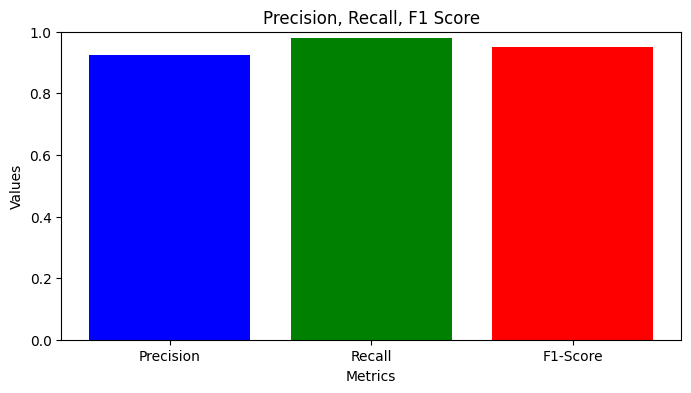

In [25]:
# After model training
predictions = model.predict(X_dev)
predictions = (predictions > 0.5).astype(int)

# Calculate metrics
precision, recall, fscore, _ = score(y_dev, predictions, average='binary')

# Plotting
metrics = [precision, recall, fscore]
metric_names = ['Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(8, 4))
plt.bar(metric_names, metrics, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Precision, Recall, F1 Score')
plt.ylim(0, 1)
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


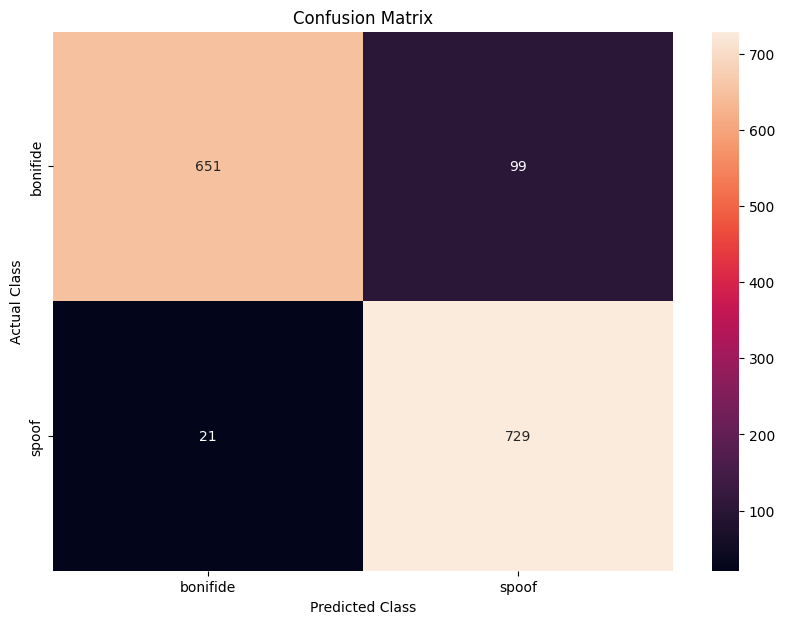

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def predict_and_evaluate(model, X, y_true, class_labels):
    """Predicts using the model and evaluates using a confusion matrix."""
    # Predict the outcomes for the evaluation dataset
    y_pred = model.predict(X)
    y_pred = np.round(y_pred).astype(int)  # Convert probabilities to class labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

predict_and_evaluate(model, X_eval, y_eval, ['bonifide','spoof'])


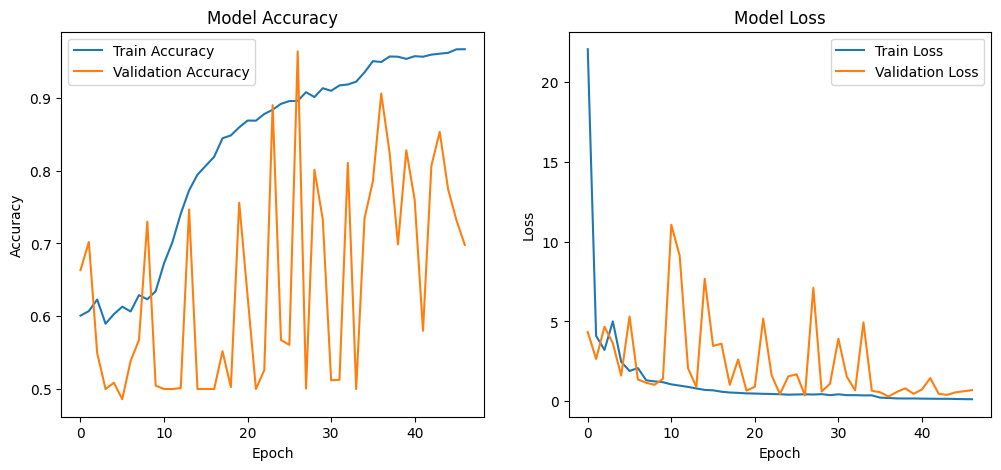

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [18]:
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.models import load_model
import librosa
import numpy as np

# Load your trained model
model = load_model('best_model.keras')

def preprocess_audio(file_path):
    # Audio parameters
    SAMPLE_RATE = 16000
    DURATION = 20.0  # Expected duration in seconds
    AUDIO_LEN = int(SAMPLE_RATE * DURATION)
    
    # Spectrogram parameters
    N_MELS = 128  # Frequency axis size
    N_FFT = 2048  # FFT window size
    SPEC_WIDTH = 256  # Time axis size
    HOP_LEN = 512  # Hop length (stride)
    FMAX = SAMPLE_RATE // 2  # Maximum frequency

    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # If the audio is shorter than the required duration, pad it
    if len(audio) < AUDIO_LEN:
        pad_len = AUDIO_LEN - len(audio)
        audio = np.pad(audio, (0, pad_len), mode='constant')

    # Generate a Mel-spectrogram
    spectrogram = librosa.feature.melspectrogram(audio, sr=SAMPLE_RATE, n_fft=N_FFT,
                                                 hop_length=HOP_LEN, n_mels=N_MELS, fmax=FMAX)
    # Convert the Mel-spectrogram to log scale (dB)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Ensure the spectrogram is 3D (height, width, channel)
    spectrogram = spectrogram[..., np.newaxis]  # add channel dimension if needed

    return spectrogram

In [19]:
def upload_and_predict():
    # Open a dialog to select a file
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav *.flac")])
    if file_path:
        # Process the audio file
        processed_audio = preprocess_audio(file_path)
        # Predict (assuming your model expects a batch dimension, we add one with np.expand_dims)
        prediction = model.predict(np.expand_dims(processed_audio, axis=0))
        predicted_class = np.argmax(prediction)  # assuming a classification problem
        class_labels = ['bonifide', 'spoof']  # update class labels as per your model's training
        # Display the prediction
        result_label.config(text=f"Predicted Class: {class_labels[predicted_class]}, Confidence: {np.max(prediction)}")


In [20]:
# root = tk.Tk()
# root.title("Audio File Upload for Prediction")

# # Create a button to upload files
# upload_button = tk.Button(root, text="Upload and Predict", command=upload_and_predict)
# upload_button.pack(pady=20)

# # Label to display the prediction result
# result_label = tk.Label(root, text="", font=('Helvetica', 14))
# result_label.pack(pady=20)

# # Start the GUI
# root.mainloop()